# Applying the Expected Context Framework to Parliamentary Question Periods

This notebook demonstrates an application of the Expected Context Framework to analyze question periods in the British House of Commons. We will principally use the framework to derive a typology of questions based on their rhetorical role; later in the notebook, we'll explore some other properties that the framework derives. 

An earlier version of the method is implemented via the `PromptTypes` module in ConvoKit, and is demoed [here](https://github.com/CornellNLP/ConvoKit/blob/master/examples/prompt-types/prompt-type-demo.ipynb). That version, and more details on the dataset, are found in [this paper](http://www.cs.cornell.edu/~cristian/Asking_too_much.html). Details about the Expected Context Framework, and the extended analyses presented below, can be found in [this dissertation](https://tisjune.github.io/research/dissertation).

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import math
import os

## 1. Loading and preprocessing the training data

In [3]:
from convokit import Corpus
from convokit import download

In [4]:
# OPTION 1: DOWNLOAD CORPUS 
# UNCOMMENT THESE LINES TO DOWNLOAD CORPUS
# DATA_DIR = '<YOUR DIRECTORY>'
# PARL_CORPUS_PATH = download('parliament-corpus', data_dir=DATA_DIR)

# OPTION 2: READ PREVIOUSLY-DOWNLOADED CORPUS FROM DISK
# UNCOMMENT THIS LINE AND REPLACE WITH THE DIRECTORY WHERE THE TENNIS-CORPUS IS LOCATED
PARL_CORPUS_PATH = '<YOUR DIRECTORY>'

In [5]:
parl_corpus = Corpus(PARL_CORPUS_PATH)

In [6]:
parl_corpus.print_summary_stats()

Number of Speakers: 1978
Number of Utterances: 433787
Number of Conversations: 216894


We represent questions and answers as dependency-parse arcs, which we load separately below. In order to capture rhetorical rather than topical information, we remove nouns; furthermore, we only examine the parts of a question that contain the actual question (i.e., we only extract features from sentences in questions that end in question-marks, and ignore the surrounding text). It's worth playing around with the feature representation; for instance, future work could examine output with nouns left in.

In [7]:
parl_corpus.load_info('utterance',['arcs','q_arcs'])

## 2. Applying the Expected Context Framework

In [8]:
from convokit.expected_context_framework import ColNormedTfidfTransformer, ExpectedContextModelTransformer

To apply the Expected Context Framework, we start by converting the input utterance text to an input vector representation. Here, we represent utterances in a term-document matrix that's _normalized by columns_ (empirically, we found that this ensures that the representations derived by the framework aren't skewed by the relative frequency of utterances). We use the `ColNormedTfidfTransformer` transformer to do this.

We derive different tf-idf representations (with different vocabularies and other parameters) for questions and answers, since the two are fairly linguistically different (in particular, we'd like to make sure we capture question-specific constructions). We make this partitioning by passing different selectors into the `fit` function calls below. 

Note that we set `max_df`, governing the maximum % of utterances in which a term can appear to be considered in our vocabulary, to be quite low, in order to omit very generic terms that we found resulted in noisier output. These parameters can be toggled with as well.

In [9]:
q_tfidf_obj = ColNormedTfidfTransformer(input_field='q_arcs', output_field='q_arc_tfidf',
                                    min_df=100, max_df=.1, binary=False)
q_tfidf_obj.fit(parl_corpus, selector=lambda x: x.meta['is_question'] and x.meta['pair_has_features'])
print(len(q_tfidf_obj.get_vocabulary()))

1152


In [10]:
a_tfidf_obj = ColNormedTfidfTransformer(input_field='arcs', output_field='arc_tfidf',
                                    min_df=100, max_df=.1, binary=False)
a_tfidf_obj.fit(parl_corpus, selector=lambda x: x.meta['is_answer'] and x.meta['pair_has_features'])
print(len(a_tfidf_obj.get_vocabulary()))

2706


In [11]:
_ = q_tfidf_obj.transform(parl_corpus, selector=lambda x: x.meta['is_question'] and x.meta['pair_has_features'])
_ = a_tfidf_obj.transform(parl_corpus, selector=lambda x: x.meta['is_answer'] and x.meta['pair_has_features'])

We then initialize an Expected Context model.
* We specify the conversational context we will derive our question representations from is the answers they get. IDs of answers for each question are stored in the `next_id` metadata field, which we pass into the constructor as `context_field='next_id'`
* as input, the model will use tf-idf representations from `vect_field=first_tfidf` to represent comments, and `context_vect_field=second_tfidf` to represent context comments
* we'll derive `n_svd_dims=25`-dimensional representations, and infer `n_clusters=8` clusters or question types. These parameters can also be toggled with -- more clusters and higher dimensions might result in finer, if potentially less interpretable, distinctions being made between questions.
* `output_prefix='fw'` means that the various attributes and vectors that the transformer will eventually write to all have the prefix `fw` in their names.

In [12]:
q_ec = ExpectedContextModelTransformer(
    context_field='next_id', output_prefix='fw', 
    vect_field='q_arc_tfidf', context_vect_field='arc_tfidf',
      n_svd_dims=25, n_clusters=8,
      random_state=1000, cluster_random_state=1000)

(the following call takes some time to run)

In [13]:
q_ec.fit(parl_corpus, selector=lambda x: x.meta['is_question'] and (x.meta.get('q_arc_tfidf__n_feats',0)>0),
        context_selector=lambda x: x.meta['is_answer'] and (x.meta.get('arc_tfidf__n_feats',0)>0))

### Inferred question types

Below we print representative terms, questions, and answers/answer terms for the types we've inferred (note that the output is quite long):

In [14]:
q_ec.print_clusters(corpus=parl_corpus)

CLUSTER 0 0
---
terms
                  cluster_dist
index                         
share_*               0.561461
welcome_*             0.565564
share_does            0.604726
congratulate_*        0.616394
use_*                 0.617847
am_*                  0.627405
impress_on            0.635085
encourage_*           0.646977
congratulate_may      0.664214
join_*                0.678611

context terms
              cluster_dist
index                     
is_important      0.557533
hope_*            0.567806
have_can          0.570490
encourage_*       0.571406
is_ensure         0.596783
and>*             0.613320
is_have           0.614779
hope_do           0.620393
is_get            0.628049
is_do             0.628658


utterances
> 2006-01-12b.407.2 0.425 The Minister knows how fervently the Opposition support his work to encourage links between the universities and industry . In that spirit of cross - party consensus on higher education , will he join me in supporting all those 

demo continues below

Per our interpretation, we assign the following names to these clusters:

In [15]:
q_ec.set_cluster_names(['shared_concern', 'request_assurance', 'prompt_comment', 'agreement', 
                         'issue_update', 'question_premises', 'accept_propose', 'demand_account'])

In [16]:
q_ec.print_cluster_stats()

,utts,terms,context_utts,context_terms
accept_propose,0.184516,0.150174,0.147930,0.139690
agreement,0.080253,0.047743,0.078630,0.052106
demand_account,0.131033,0.137153,0.071226,0.071693
issue_update,0.092242,0.128472,0.123574,0.167036
prompt_comment,0.162576,0.168403,0.131228,0.129342
question_premises,0.143333,0.165799,0.133372,0.144863
request_assurance,0.127051,0.098090,0.122071,0.104952
shared_concern,0.078997,0.104167,0.191969,0.190318


Finally, we transform the corpus with the fitted model:

In [17]:
_ = q_ec.transform(parl_corpus, selector=lambda x: x.meta['is_question'] and (x.meta.get('q_arc_tfidf__n_feats',0)>0))

# this call derives representations of answers, following our method.
_ = q_ec.transform_context_utts(parl_corpus, selector=lambda x: x.meta['is_answer'] and (x.meta.get('arc_tfidf__n_feats',0)>0)) 

Here are the attributes we derive for an example utterance, via the transform call:

In [18]:
ut_eg_id = '2010-03-25c.364.5'
eg_ut = parl_corpus.get_utterance(ut_eg_id)
print(eg_ut.text)

I thank the Minister for that reply . He knows that 2009 was another difficult year for many British farmers . Will he explain why Government procurement of British food actually fell during that year , and in particular , why NHS procurement dropped sharply ? Why are the Government failing to back British farmers and British food at this time ?


Our example is assigned to the "Demand for Account" type. We suggest this makes sense, given the confrontational and interrogative nature of the question. We also store the distance between the representation of the question and its corresponding cluster centroid.

In [19]:
eg_ut.meta['fw_clustering.cluster'], eg_ut.meta['fw_clustering.cluster_dist']

('prompt_comment', 0.6094370409124481)

Vector representations are stored with the corpus in a matrix called `fw_repr`, and can be accessed as follows:

In [20]:
parl_corpus.get_vectors('fw_repr',[ut_eg_id])
# technical note: for an explanation of why there are only 24 dimensions, instead of 25, see the `snip_first_dim` parameter in the documentation

array([[-0.30727219, -0.13173684, -0.09564039,  0.26725832, -0.03839751,
        -0.17965502, -0.26523116,  0.12426359,  0.11925108, -0.06012806,
        -0.17136398, -0.01314043, -0.19893231, -0.10331306, -0.05066268,
         0.27480168, -0.16588479,  0.13608597, -0.17576715,  0.5174909 ,
        -0.06604386, -0.03586687, -0.3779309 , -0.13857462]])

We also compute a statistic called "range" for the utterance. One way to interpret this statistic is as a way of quantifying the strengths of our expectations: lower values mean that we expect a narrower range of possible replies (i.e., stronger expectations). See [this dissertation](https://tisjune.github.io/research/dissertation) for more explanation of this statistic, and a few caveats on applying it in this setting, with our methodological choices. We'll briefly explore the range statistic later on.

In [21]:
eg_ut.meta['fw_range']

0.8090945361491606

## 3. Analysis of question types

We will relate the inferred question types to two key attributes of question-askers: their party affiliation (whether they are part of the governing party, or the official opposition), and their tenure (number of years since they were first elected). For more details on these attributes and on our motivations, see [this dissertation](https://tisjune.github.io/research/dissertation). 

For convenience, we start by loading relevant attributes into a Pandas dataframe.

In [23]:
for ut in parl_corpus.iter_utterances():
    ut.meta['speaker'] = ut.speaker.id
utt_meta_df = parl_corpus.get_attribute_table('utterance',
                ['fw_clustering.cluster','govt', 'govt_coarse','is_question','is_answer',
                'is_incumbent','is_oppn','speaker','party', 'tenure','next_id'])

The dataset is somewhat spotty in terms of when it includes party affiliation information, but tends to be worse about this during the Thatcher and Major governments. We filter out questions which we think have missing information accordingly:

In [24]:
utt_meta_sub = utt_meta_df[((utt_meta_df.is_incumbent == True) | (utt_meta_df.is_oppn == True))
                    & (utt_meta_df.speaker != '<UNKNOWN>') & (utt_meta_df.party.notnull())
                    & (utt_meta_df.govt_coarse != 'thatcher+major')
                    & (utt_meta_df['fw_clustering.cluster'].notnull())].copy()

To examine the extent to which a question type tends to be asked more by a member of the government vs official opposition, we compute log-odds ratios. The next few cells perform these computations to render a figure of log-odds ratio per question type.

In [25]:
def compute_log_odds(col, bool_col, val_subset=None):
    if val_subset is not None:
        col_vals = val_subset
    else:
        col_vals = col.unique()
    log_odds_entries = []
    for val in col_vals:
        val_true = sum((col == val) & bool_col)
        val_false = sum((col == val) & ~bool_col)
        nval_true = sum((col != val) & bool_col)
        nval_false = sum((col != val) & ~bool_col)
        log_odds_entries.append({'val': val, 'log_odds': np.log((val_true/val_false)/(nval_true/nval_false))})
    return log_odds_entries

In [26]:
log_odds_party  = []
for cname in q_ec.get_cluster_names():
    entry =  compute_log_odds(utt_meta_sub['fw_clustering.cluster'],utt_meta_sub['is_incumbent'],
                             val_subset=[cname])
    log_odds_party += entry
log_odds_party_df = pd.DataFrame(log_odds_party).set_index('val')

In [27]:
type_order = log_odds_party_df.sort_values('log_odds').index


In [28]:
display_names = ['Demand for account', 'Questioning premises', 'Prompt for comment',
                            'Accept and propose', 'Req. for assurance', 'Issue update', 
                            'Shared concerns', 'Agreement']

In [29]:
from matplotlib import pyplot as plt
%matplotlib inline

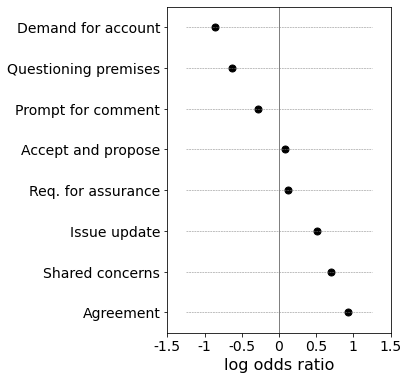

In [30]:
fig, ax = plt.subplots(figsize=(4,6))
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-.5,7.5)
for i,cname in enumerate(type_order):
    log_odds = log_odds_party_df.loc[cname].log_odds
    ax.scatter([log_odds], [i], color='black',s=49)
    ax.plot([-1.25,1.25],[i,i],'--', color='grey', linewidth=.5)
ax.plot([0,0],[-2,8], color='grey', linewidth=1)
ax.invert_yaxis()
ax.set_yticks(np.arange(len(type_order)))
ax.set_yticklabels(display_names, fontsize=14)
ax.set_xticklabels([-1.5,-1,-.5,0,.5,1,1.5], fontsize=14)
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)
ax.set_xlabel('log odds ratio', fontsize=16)
None

Here, points further to the right indicate question types more likely to be asked by government-affiliated askers; points to the left indicate types more likely to be asked by the opposition. This passes a sanity check: more aggressive questions tend to be asked more by opposition askers, while more positive, bolstering types are asked more by government askers.

To examine the relationship between question type and tenure, we compute the median tenure of askers per type. Since we know that different types might be asked more by govt vs opposition members, and since opposition members tend to be more tenured, we separate this analysis by affiliation, resulting in the plot a few cells down:

In [31]:
med_tenures = pd.concat([utt_meta_sub[utt_meta_sub.is_incumbent].groupby('fw_clustering.cluster').tenure.median().rename('govt'),
utt_meta_sub[~utt_meta_sub.is_incumbent].groupby('fw_clustering.cluster').tenure.median().rename('oppn')], axis=1)
med_in_tenure = utt_meta_sub[utt_meta_sub.is_incumbent].tenure.median()
med_op_tenure = utt_meta_sub[~utt_meta_sub.is_incumbent].tenure.median()

In [32]:
med_tenures

,govt,oppn
fw_clustering.cluster,,
accept_propose,9.946575,11.545205
agreement,4.890411,9.221918
demand_account,6.845205,10.221918
issue_update,4.882192,8.417808
prompt_comment,6.449315,8.680822
question_premises,9.030137,9.697260
request_assurance,6.460274,9.600000
shared_concern,5.613699,10.010959


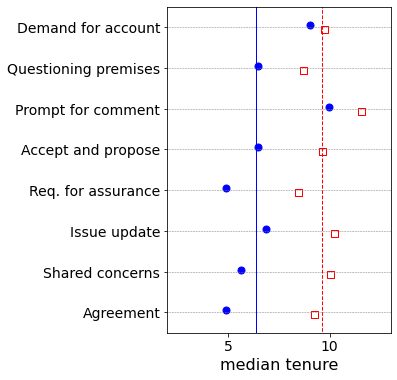

In [33]:
fig, ax = plt.subplots(figsize=(4,6))
ax.set_xlim(2, 13)
ax.set_ylim(-.5,7.5)
for i,cname in enumerate(type_order):
    ax.scatter([med_tenures.loc[cname].govt],[i-.05], s=49, color='blue')
    ax.scatter([med_tenures.loc[cname].oppn],[i+.05], s=49, color='red', facecolor='white',marker='s')
    ax.plot([.5,14.5],[i,i],'--', color='grey', linewidth=.5)
ax.plot([med_in_tenure, med_in_tenure],[-2,8], color='blue',linewidth=1)
ax.plot([med_op_tenure, med_op_tenure],[-2,8], '--', color='red', linewidth=1)
ax.invert_yaxis()
ax.set_xticks([5,10])
ax.set_xticklabels([5,10], fontsize=14)
ax.set_yticks(np.arange(8))
ax.set_yticklabels(display_names, fontsize=14)
ax.set_xlabel('median tenure', fontsize=16)
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

One interesting thing to point out is that among questions asked by government affiliated members, aggressive (e.g., **demand for account**) questions tend to be asked more by older askers (indicated by blue dots) -- that is, it seems that as parliamentarians get more tenured, they ask more aggressive questions. Note that the ministers answering these questions are almost always affiliated with the government, so this means that older askers are more aggressive, even towards members of their own party. In [this dissertation](https://tisjune.github.io/research/dissertation) we more carefully examine this observation.

## 4. Other applications of the Expected Context Framework

### Answer types

Note that we can also try to infer types of _answers_, instead of types of questions. To do this, we initialize a new Expected Context Model with some modifications to the arguments passed in: 

In [34]:
a_ec = ExpectedContextModelTransformer(
    context_field='reply_to', output_prefix='bk', 
    vect_field='arc_tfidf', context_vect_field='q_arc_tfidf',
      n_svd_dims=15, n_clusters=5,
      random_state=1000, cluster_random_state=1000)

In [35]:
a_ec.fit(parl_corpus, selector=lambda x: x.meta['is_answer'] and (x.meta.get('arc_tfidf__n_feats',0)>0),
         context_selector=lambda x: x.meta['is_question'] and (x.meta.get('q_arc_tfidf__n_feats',0)>0))

In [36]:
a_ec.print_clusters(corpus=parl_corpus)

CLUSTER 0 0
---
terms
              cluster_dist
index                     
welcome_*         0.173558
is_take           0.179574
indeed>*          0.206015
support_*         0.208702
is_important      0.218273
is_right          0.218688
agree_on          0.219922
be_should         0.227413
hope_is           0.230160
is_course         0.232897

context terms
               cluster_dist
index                      
agree_is           0.267424
agree_are          0.291674
however>*          0.294775
agree_with         0.306583
is_however         0.326577
seek_*             0.337093
agree_further      0.340146
agree_however      0.348032
agree_be           0.353457
seek_will          0.354214


utterances
> 1992-02-05a.280.6 0.072 I entirely agree with my hon Friend . The House will know that 46 British inspectors have been involved in the process of inspection within Iraq . Certainly I pay tribute to them and to their colleagues from other countries . On the second part of my hon Friend 's

We suggest that the types inferred are slightly messier than those inferred for questions, though there are still discernable interpretations:

In [37]:
a_ec.set_cluster_names(['progress_report', 'statement', 'endorsement', 'comment', 'commitment'])

In [38]:
a_ec.print_cluster_stats()

,utts,terms,context_utts,context_terms
comment,0.042213,0.115299,0.137920,0.155382
commitment,0.395989,0.328899,0.336692,0.357639
endorsement,0.258554,0.209165,0.100145,0.098090
progress_report,0.123028,0.145233,0.278981,0.222222
statement,0.180216,0.201404,0.146261,0.166667


As with question types, we'll briefly examine the relation between answer types and speaker affiliation. Here, we relate types to the affiliation of the _asker of the question_ for which the answer is provided.

In [39]:
_ = a_ec.transform(parl_corpus, selector=lambda x: x.meta['is_answer'] and (x.meta.get('arc_tfidf__n_feats',0)>0))

In [40]:
a_utt_meta_df = parl_corpus.get_attribute_table('utterance',
                ['bk_clustering.cluster'])
a_utt_meta_sub = a_utt_meta_df.join(utt_meta_df[((utt_meta_df.is_incumbent == True) | (utt_meta_df.is_oppn == True))
                    & (utt_meta_df.speaker != '<UNKNOWN>') & (utt_meta_df.party.notnull())
                    & (utt_meta_df.govt_coarse != 'thatcher+major')].set_index('next_id'), how='inner')
a_utt_meta_sub = a_utt_meta_sub[a_utt_meta_sub['bk_clustering.cluster'].notnull()]

In [41]:
a_utt_meta_sub.shape

(84823, 11)

In [42]:
log_odds_party_answer  = []
for cname in a_ec.get_cluster_names():
    entry =  compute_log_odds(a_utt_meta_sub['bk_clustering.cluster'],a_utt_meta_sub['is_incumbent'],
                             val_subset=[cname])
    log_odds_party_answer += entry
log_odds_party_answer_df = pd.DataFrame(log_odds_party_answer).set_index('val')

In [43]:
a_type_order = log_odds_party_answer_df.sort_values('log_odds').index

In [44]:
a_display_names = ['Statement', 'Comment', 'Progress report', 'Commitment', 'Endorsement']

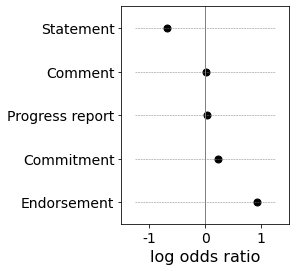

In [45]:
fig, ax = plt.subplots(figsize=(3,4))
ax.set_xlim(-1.5, 1.5)
ax.set_ylim(-.5,4.5)
for i,cname in enumerate(a_type_order):
    log_odds = log_odds_party_answer_df.loc[cname].log_odds
    ax.scatter([log_odds], [i], color='black',s=49)    
    ax.plot([-1.25,1.25],[i,i],'--', color='grey', linewidth=.5)
ax.plot([0,0],[-2,5], color='grey', linewidth=1)
ax.invert_yaxis()
ax.set_yticks(np.arange(len(a_type_order)))
ax.set_yticklabels(a_display_names, fontsize=14)
ax.set_xlabel('log odds ratio', fontsize=16)
ax.set_xticks([-1,0,1])
ax.set_xticklabels([-1,0,1], fontsize=14)
None

### Ranges

We briefly examine the range statistic we computed for each utterance. Below, we plot distributions of ranges for questions of each inferred type, as box plots:

In [46]:
utt_range_df = parl_corpus.get_attribute_table('utterance',
                ['fw_clustering.cluster','fw_range'])
utt_range_df = utt_range_df[utt_range_df.fw_range.notnull()].copy()

In [47]:
fw_range_distrs = utt_range_df.groupby('fw_clustering.cluster').fw_range.describe().sort_values('50%')
med_range_full = utt_range_df.fw_range.median()

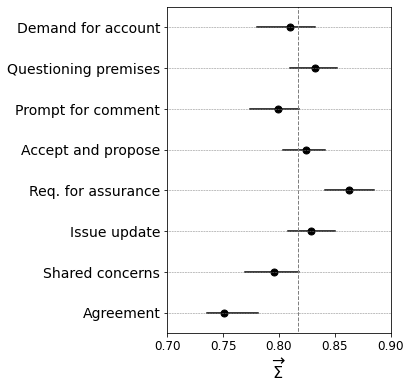

In [48]:
fig, ax = plt.subplots(figsize=(4,6))
ax.set_xlim(.7, .9)
ax.set_ylim(-.5,7.5)
for i,cname in enumerate(type_order):
    med_range = fw_range_distrs.loc[cname]['50%']
    left = fw_range_distrs.loc[cname]['25%']
    right = fw_range_distrs.loc[cname]['75%']
    ax.scatter([med_range], [i], color='black',s=49)
    ax.plot([left,right],[i,i], color='black')
    ax.plot([-1.25,1.25],[i,i],'--', color='grey', linewidth=.5)
ax.plot([med_range_full,med_range_full],[-2,8], '--', color='grey', linewidth=1)
ax.invert_yaxis()
ax.set_yticks(np.arange(len(type_order)))
ax.set_yticklabels(display_names, fontsize=14)
ax.set_xlabel('$\overrightarrow{\Sigma}$', fontsize=16)
plt.rc('xtick',labelsize=14)
plt.rc('ytick',labelsize=14)


We note that the **agreement** question type tends to have lower forwards ranges than the rest, and suggest this reflects the relatively routine, formulaic nature of an exchange involving this question type ("Do you agree?" "I agree completely.")

## 5. Pipeline usage

We can also apply the framework via a pipeline that handles the following:
* processes text (via a pipeline supplied by the user; see cell below)
* transforms text to input representation (via `ColNormedTfidfTransformer`)
* derives framework output (via `ExpectedContextModelTransformer`)

In [49]:
from convokit.expected_context_framework import ExpectedContextModelPipeline

In [50]:
# see `demo_text_pipelines.py` in this demo's directory for details
# in short, this pipeline will compute the question and answer dependency-parse arcs,
# but will skip over utterances for which these attributes already exist
from demo_text_pipelines import parliament_arc_pipeline

We initialize the pipeline with the following arguments:
* `text_field` specifies which utterance metadata field to use as text input; `context_text_field` specifies the field to use as text input for context-utterances;
* `share_tfidf_models` indicates whether we want to train one `ColNormedTfidfTransformer` model for both utterances and context-utterances. In this case, since we want different input representations for questions and answers, we set this argument to `False`.
* `text_pipe` specifies the pipeline used to compute the contents of `text_field`
* `tfidf_params` specifies the parameters to be passed into the underlying `ColNormedTfidfTransformer` object
* `min_terms` specifies the minimum number of terms in the vocabulary that an utterance must contain for it to be considered in fitting and transforming the underlying `ExpectedContextModelTransformer` object (see the `selector` argument passed into `q_ec.fit` above)

All other arguments are inherited from `ExpectedContextModelTransformer`.

In [51]:
q_pipe = ExpectedContextModelPipeline(context_field='next_id', output_prefix='fw',
        text_field='q_arcs', context_text_field='arcs', share_tfidf_models=False,
        text_pipe=parliament_arc_pipeline(), 
        tfidf_params={'binary': False, 'min_df': 100, 'max_df': .1}, 
        min_terms=1,
        n_svd_dims=25, n_clusters=8, cluster_on='utts',
        random_state=1000, cluster_random_state=1000)

In [52]:
q_pipe.fit(parl_corpus,
    selector=lambda x: x.meta['is_question'] and x.meta['pair_has_features'],
    context_selector=lambda x: x.meta['is_answer'] and x.meta['pair_has_features'])

This should produce the same output as calling the constituent steps separately.

In [53]:
q_pipe.ec_model.print_clusters()

CLUSTER 0 0
---
terms
                  cluster_dist
index                         
share_*               0.561461
welcome_*             0.565564
share_does            0.604726
congratulate_*        0.616394
use_*                 0.617847
am_*                  0.627405
impress_on            0.635085
encourage_*           0.646977
congratulate_may      0.664214
join_*                0.678611

context terms
              cluster_dist
index                     
is_important      0.557533
hope_*            0.567806
have_can          0.570490
encourage_*       0.571406
is_ensure         0.596783
and>*             0.613320
is_have           0.614779
hope_do           0.620393
is_get            0.628049
is_do             0.628658

CLUSTER 1 1
---
terms
              cluster_dist
index                     
give_*            0.427345
give_can          0.526360
give_will         0.528818
see_*             0.541311
assure_will       0.549835
assure_*          0.584025
discuss_*         0.591057
h

In [54]:
q_pipe.set_cluster_names(['shared_concern', 'request_assurance', 'prompt_comment', 'agreement', 
                         'issue_update', 'question_premises', 'accept_propose', 'demand_account'])

The pipeline enables us to transform ad-hoc string input.

In [55]:
new_ut = q_pipe.transform_utterance(
    'Can the Minister please explain why the reopening was delayed?')

In [56]:
print('question type:', new_ut.meta['fw_clustering.cluster'])

question type: prompt_comment


Here, instead of storing vector representations with a corpus, the pipeline writes these representations to a field in the utterance metadata itself (since the utterance is not attached to a corpus):

In [57]:
# note that different versions of SpaCy may produce different outputs, since the
# dependency parses may change from version to version
new_ut.meta['fw_repr']

[-0.2296570739443364,
 0.10581579121624114,
 0.07254644720723367,
 0.20469517320080635,
 0.10699971871019655,
 -0.13490207014441047,
 -0.26702240703759755,
 0.13488915445375704,
 0.15966352756360683,
 0.010734218061526093,
 -0.20582957448247755,
 -0.030080948810664185,
 -0.12532196977015536,
 -0.1767950015555799,
 -0.24238622998072742,
 0.3250296440986241,
 -0.30609142098397113,
 0.17088641599100582,
 -0.07358702431958357,
 0.4387561934516926,
 0.061390643835384485,
 0.006236864476233286,
 -0.39667464447326534,
 -0.08685370687786637]